# The Perceptron

In [4]:
import numpy as np
import scipy 
import  matplotlib.pyplot as plt 
import h5py 
from PIL import Image
from scipy import ndimage

## Importing cat's dataset :

In [5]:
def load_dataset():
    with h5py.File('datasets/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('datasets/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes 

In [6]:

x_train, y_train, x_test, y_test, classes = load_dataset()

### Printing informations about the dataset :

In [7]:
print("Size of the training dataset : ",y_train.shape)
print("Size of the testing dataset : ",y_test.shape)
print("Size of the image : ",x_train[0].shape)
print("shape of training dataset : ",x_train.shape)


Size of the training dataset :  (1, 209)
Size of the testing dataset :  (1, 50)
Size of the image :  (64, 64, 3)
shape of training dataset :  (209, 64, 64, 3)


NB: The size of the image is 64/64 px but there is a third dimention of shape 3 
this is because the image is composed of three layers: a red layer, a blue layer, and a green layer (RGB).Each value in each layer is between 0 and 255, 

## flatening images :
to be able to feed our algorithm with images, we need to flatten each of our image into a  vector, we will use the reshape function for this \
reshape take the new shape and return new shaped array \
in our case the initial shape is (209, 64, 64, 3)
which can be decomposed into 2 parts
- 209 : the number of images 
- 64, 64, 3 : dimensions of each image of our dataset 
the second part will be the part conserned by the flattening thats why we will use the reshape as follow :
> `flat_x_train = x_train.reshape(x_train.shape[0], -1)`

- The first argument we gave to reshape is `x_train.shape[0]` witch is 209, the number of images, the part of the initial shape that we want to keep 
- The segon argument is `-1` whitch indicate to the function to put the rest in one shape part \
which give to our new dataset the shape of 
(209, 12288) 

In [8]:
#plt.imshow(x_train[11])
img = x_train[11]
x_train.shape
flat_x_train = x_train.reshape(x_train.shape[0], -1)
flat_x_test = x_test.reshape(x_test.shape[0], -1)

print("flat_x_train.shape", flat_x_train.shape)
print("flat_x_test.shape", flat_x_test.shape)

flat_x_train.shape (209, 12288)
flat_x_test.shape (50, 12288)


## Standardisation:
we divide the pixels values of flattened images by the maximum value a pixel can have to let them values fluctuate between 0 and 1


In [9]:
train_set_x = flat_x_train / 255
test_set_x = flat_x_test / 255

## Activation function :
as our problem is a problem of classification we choose the sigmoid function :
$$y=\frac{1}{1+e^{-z}}$$

z is a liear function :
$$ z = x_1.w_1+x_2.w_2 + b $$
this function plot a line named desition bondary this line split cases on 2 cathegories
- positif cases z > 0 
- negative case z < 0 \  
we put this function on a segmoid because we need to deal with probabilities
with this setting :
- when z tends to +inf y tends to 1
- when z tends to -inf y tends to 0
- when z tends to 0 y tends to 0.5 which will be our threshold to decide between the cases \
<img src="img/y.png">


### let's define it :

In [10]:
def sigmoid(z):
   return 1 / (1 + np.exp(-z))

def linear_function(X, W, b):
    linear_y_hat = np.dot(X , W) + b
    return linear_y_hat

def init_with_zero(dim):
    W = np.zeros((dim, 1))
    b = 0
    return W, b

## Cost function :

#### Theori :
The main purpuse of the cost function is to penalize our algorithm when the prediction $\hat{y}$ is diferent from the y of the dataset
- if $y = 0$ the result of our cost function shoul be bigger when $\hat{y}$ approaches 1
- if $y = 1$ the result of our cost function shoul be bigger when $\hat{y}$ approaches 0

we will use the property of the exponential base logarithm function 

- if $y = 0$ we use $$-\log{(\hat{y})}$$this function will approches to $+\infty$ when $\hat{y}$ approches 1 and 0 when $\hat{y}$ approches 0

- if $y = 1$ we use $$-\log{(1-\hat{y})}$$, this function will approches to $+\infty$ when $\hat{y}$ approches 0 and 0 when $\hat{y}$ approches 1
#### Pythonic demonstration :
please look at the file ./demo/the_cost_evolution.py for pythonic demonstration of the plots below
<img src="img/the_cost_evolution.png">

This function:
$$ -y_i\log{\hat{y}}-(1 - y_i)\log{(1 - \hat{y}_i)}$$
is the combination of the 2 functions that we have seen before because
- if y = 1 this function become : 
$$-\log{(\hat{y})}$$ 
- then if y = 0 it become $$-\log{(1-\hat{y})}$$
when y and $\hat{y}$ are different this function will tend to +$\infty$ when they are not the function tend to 0 
so this is the perfect setting to maximise cost when y and $\hat{y}$ are different
as the cost function should be the avrage of all costs, the function become :
$$J = - \frac{1}{m} \sum_{i = 1}^{m} y_i\log{\hat{y}_i}+(1 - y_i)\log{(1 - \hat{y}_i)}$$
- <em>m is the size of the dataset</em>
<img src="img/logloss_plot.png">


## Gradient descent
The idea of gradient descent is to iterate a function that will update each time our parameters until we get the best model that matches our dataset
the function of the gradient descent will be almost the same as for linear regression:
$$ \theta_j = \theta_j - \alpha . \frac{\partial J}{\partial \theta_j} $$
- $j$ is iteration index over epoch
- epoch is times the algorithm will iterate 
- $\alpha$ is the learning rates
- $\frac{\partial J}{\partial \theta_j}$ : derivative of the cost function 
<p>
the derivative give us the slope of a function :
- if the sign of the derivative is negative it mean that we have a downward slope
- if the sign of the derivative is positive it mean that we have a a rising slope
<p>knowing that the logloss is a convex function (as we can see in the plot), if we need to find its minimum we will need to move forward if the sign of the derivative is negative (because we are in downslope) and backwards if the sign is positive (because we are in upslope)</p></p>


##### NB:  this must be done on all of our parameters $(w_1, w_2 ... w_n, b)$ separately and simultaneously for each epoch all parameters must be updated !!!
this is what the derivative of the cost function with respect to each of our parameters give us :

<img src="img/dw_db.png">


### NB remember that our linear function is $ z = x_1.w_1+x_2.w_2 + b $

- $a_i$ is the prediction $\hat{y}$ on the i'th value of our dataset it is the result of our model on the i'th example on our dataset 
- $m$ isthe size of the dataset
- $y_i$ the observation on the i'th value of our dataset

more explanation on the derivatives on this link :
https://www.youtube.com/watch?v=GzphoJOVEcE&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=11

## Vectorisation
Vectorisation is the step betwin theori and practice we need to convert all of our mathematic equation to vector for optimise the execution
#### Linear function vectorisation :
<img src="img/lfv.png">

#### Sigmoid vectorisation :
<img src="img/sv_1.png">
<img src="img/sv_2.png">


####  Cost function Vectorisation:
##### NB the multiplications contained in the cost function is not a matrix multiplication it is a simple row-by-row multiplication

<img src="img/cost_fn_vectorisation.png">


####  Gradient Vectorisation:
##### NB : X have to be transposed 

<img src="img/vectorisation_derivative.png">

##### so our formulas for Gradient Vectorisation become : 
$$\frac{\partial{L}}{\partial{W}} = \frac{1}{m} X^T . (\hat{Y} - Y)$$

and for the derivative at b vectorisation :

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{m} \sum{(\hat{Y} - Y)}$$

## Forward and backward  forward propagation:
Those are the next steps in our project 
The forward propagation is the first step.
We test our parameters with training data to see the cost through the cost function 

### forward propagation :
We test our parameters with training data to see the cost through the cost function 

In [11]:
def forward_propagation(X, Y, W, b):#ddd
    Z =linear_function(X, W, b)
    Y_hat = sigmoid(Z)
    m = X.shape[1]
    cost = - 1/m * np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
    return cost , Y_hat

### Backward propagation :
Then the backward propagation is when we apply the principle of the gradian decent to minimise our cost function the function below will be called in a loop to update each time weights and bias


In [12]:

def back_propagation(W, b, Y, Y_hat, X):
    m = X.shape[1]
    d_W = 1/m *(np.dot(X.T,(Y_hat - Y)))
    d_b = 1/m * np.sum(Y_hat - Y)
    n_W = W - learning_rate * d_W
    n_b = b - learning_rate * d_b
    return n_W, n_b


### One last detail befor runing the algorithm
The 'y' that comes from the dataset is of the shape (1, m) to make it fit our equations and avoid matrix product error, its shape should become (m, 1)

In [13]:
y_test = y_test.T
y_train = y_train.T


## Lets run the algorithme

++++++++++++++++++++++++++++
cost :  0.0014176399043640373
w :  [[ 0.01278891]
 [-0.0346842 ]
 [-0.01564346]
 ...
 [-0.01461369]
 [-0.036869  ]
 [ 0.0320314 ]]
b :  -0.007019054521018076


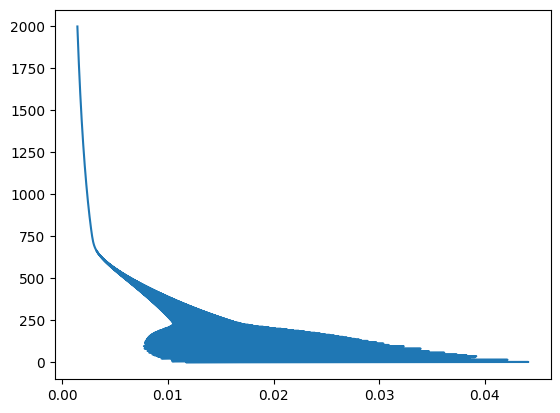

In [14]:
epoch = 2000
learning_rate = 0.5
X = train_set_x
Y = y_train
W, b = init_with_zero(X.shape[1])

costs = []
for i in range(epoch):
    cost, Y_hat = forward_propagation(X, Y, W, b)
    costs.append(cost)
    W, b = back_propagation(W, b, Y, Y_hat, X)

print("++++++++++++++++++++++++++++")
print("cost : ",cost)
#print("costs : ",costs)
print("w : ",W)
print("b : ",b)

plt.plot(costs, np.linspace(0,len(costs) - 1,len(costs)))
plt.show()

In [15]:
print("w.shape : ",W.shape)
print("X.shape : ",train_set_x.shape)

w.shape :  (12288, 1)
X.shape :  (209, 12288)


## Prediction 

In [16]:

X = test_set_x
Z =linear_function(X, W, b)
Y_hat = sigmoid(Z)
correct_prediction_tab = (Y_hat > 0.5) == y_test
correct_prediction_count = np.count_nonzero(correct_prediction_tab == True)
percentage = (correct_prediction_count * 100)/ correct_prediction_tab.size
print("correct_prediction_tab : ",correct_prediction_tab.size)
print("correct_prediction_count : ",correct_prediction_count)
print("correct prediction percentage : ",percentage)

correct_prediction_tab :  50
correct_prediction_count :  35
correct prediction percentage :  70.0


++++++++++++++++++++++++++++
y_hat : [0.91749744]
y  [1]


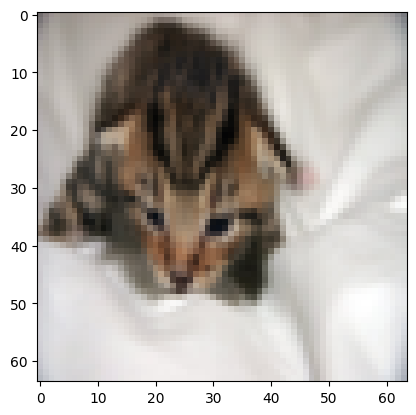

In [17]:
i = 1
X = test_set_x[i]
z =linear_function(X, W, b)
y_hat = sigmoid(z)
print("++++++++++++++++++++++++++++")
print("y_hat :",y_hat)
print("y ",y_test[i])
from PIL import Image
plt.imshow(x_test[i])
plt.show()